# Decision Tree and Random Forest(3)
* cost complexity pruning을 통하여 오버피팅을 줄이고, classification 정확도를 높여보자  
* 참고자료 : [sklearn 예시](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)
***

sklearn의 cost complexity pruning 함수를 사용하기 위해서는 버전을 업데이트 해주어야한다.

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


> 1. Run Anaconda Prompt as adminstrator
> 2. conda install scikit-learn=0.22.1

***

## Breast Cancer in [cost complexity pruning](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms) technique of DecisionTreeClassifier

In [2]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
ft = load_breast_cancer().feature_names

1. <b>Load and return the breast cancer dataset</b> : [for the further information](https://github.com/HaeHwan/dataset/blob/master/Breast%20Cancer%20Wisconsin/Breast%20Cancer%20Wisconsin.ipynb)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X.shape, X_train.shape, X_test.shape

((569, 30), (426, 30), (143, 30))

2. 0.25의 비율로 테스트와 트레이닝 데이터로 나눠놓자.

In [4]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [5]:
def draw_decision_tree(model, feature_names = None, class_names = None, proportion = False, node_ids = None) :
    dot = export_graphviz(model, feature_names = feature_names, class_names = class_names, node_ids = node_ids, proportion = proportion, filled = True)
    graph = pydot.graph_from_dot_data(dot)[0]
    image = graph.create_png()
    return Image(image)

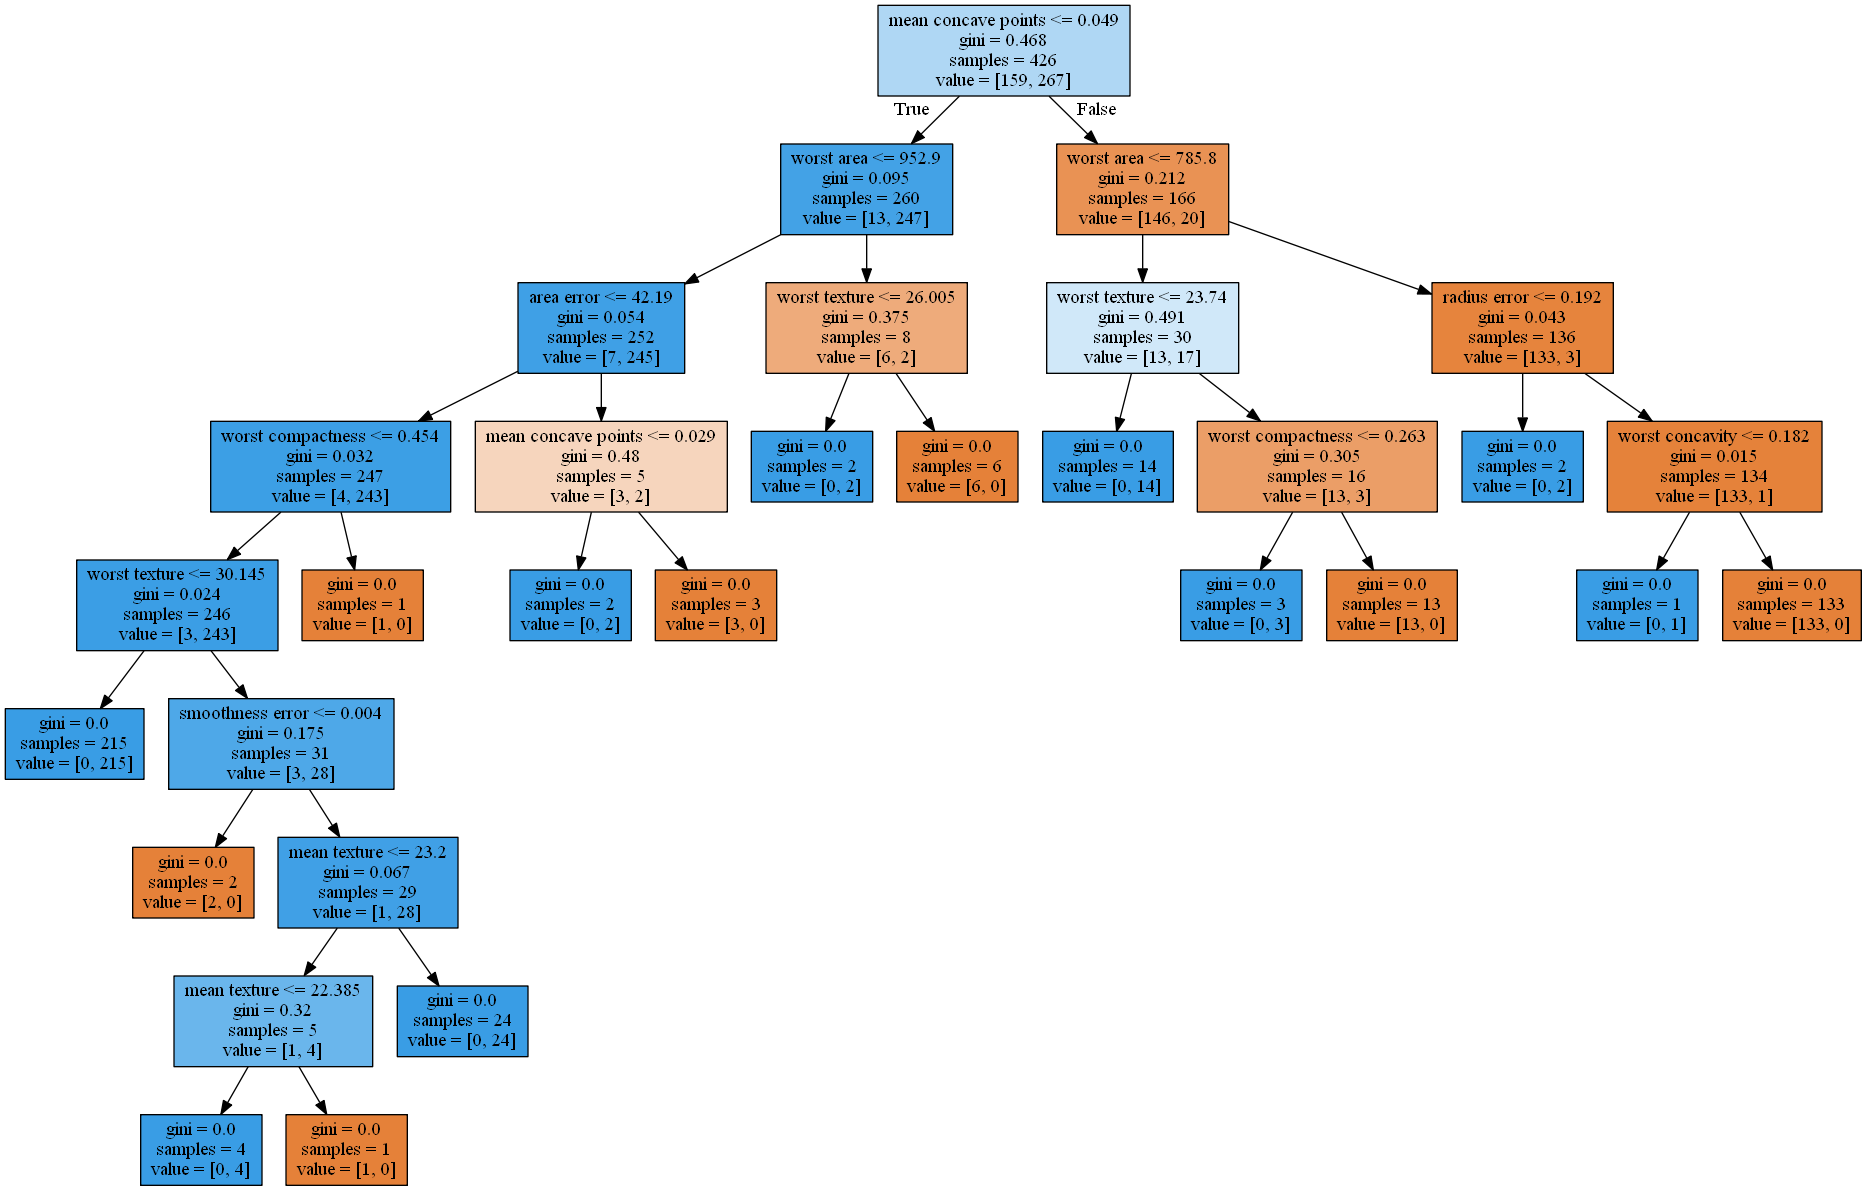

In [6]:
clf_ori = DecisionTreeClassifier(random_state=0)
tree = clf_ori.fit(X_train, y_train)
draw_decision_tree(tree, ft, node_ids = False)

In [7]:
print("별다른 튜닝 없이, decision tree 모델을 사용하면, 총 {}개의 노드가 생성된다.".format(clf_ori.tree_.node_count))

별다른 튜닝 없이, decision tree 모델을 사용하면, 총 31개의 노드가 생성된다.


***

Total impurity of leaves vs effective alphas of pruned tree
---------------------------------------------------------------
Minimal cost complexity pruning recursively finds the node with the "weakest
link". The weakest link is characterized by an effective alpha, where the
nodes with the smallest effective alpha are pruned first. To get an idea of
what values of ``ccp_alpha`` could be appropriate, scikit-learn provides
:func:`DecisionTreeClassifier.cost_complexity_pruning_path` that returns the
effective alphas and the corresponding total leaf impurities at each step of
the pruning process. As alpha increases, more of the tree is pruned, which
increases the total impurity of its leaves.



In [8]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
type(path)

sklearn.utils.Bunch

In [9]:
for k, v in path.items() :
    print("[{}]: {} <=={}개\n==========================================================================================".format(k, v[:5], len(v)))

[ccp_alphas]: [0.         0.00226647 0.00464743 0.0046598  0.0056338 ] <==13개
[impurities]: [0.         0.00453294 0.01847522 0.02313502 0.02876883] <==13개


In the following plot, the maximum effective alpha value is removed, because
it is the trivial tree with only one node.



Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

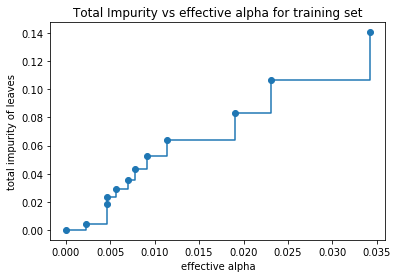

In [10]:
import matplotlib.pyplot as plt

ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

각 알파값에 따른 decision tree 결과를 시각적으로 비교해보자.

Number of nodes in the 1th tree is: 31 with ccp_alpha: 0.0


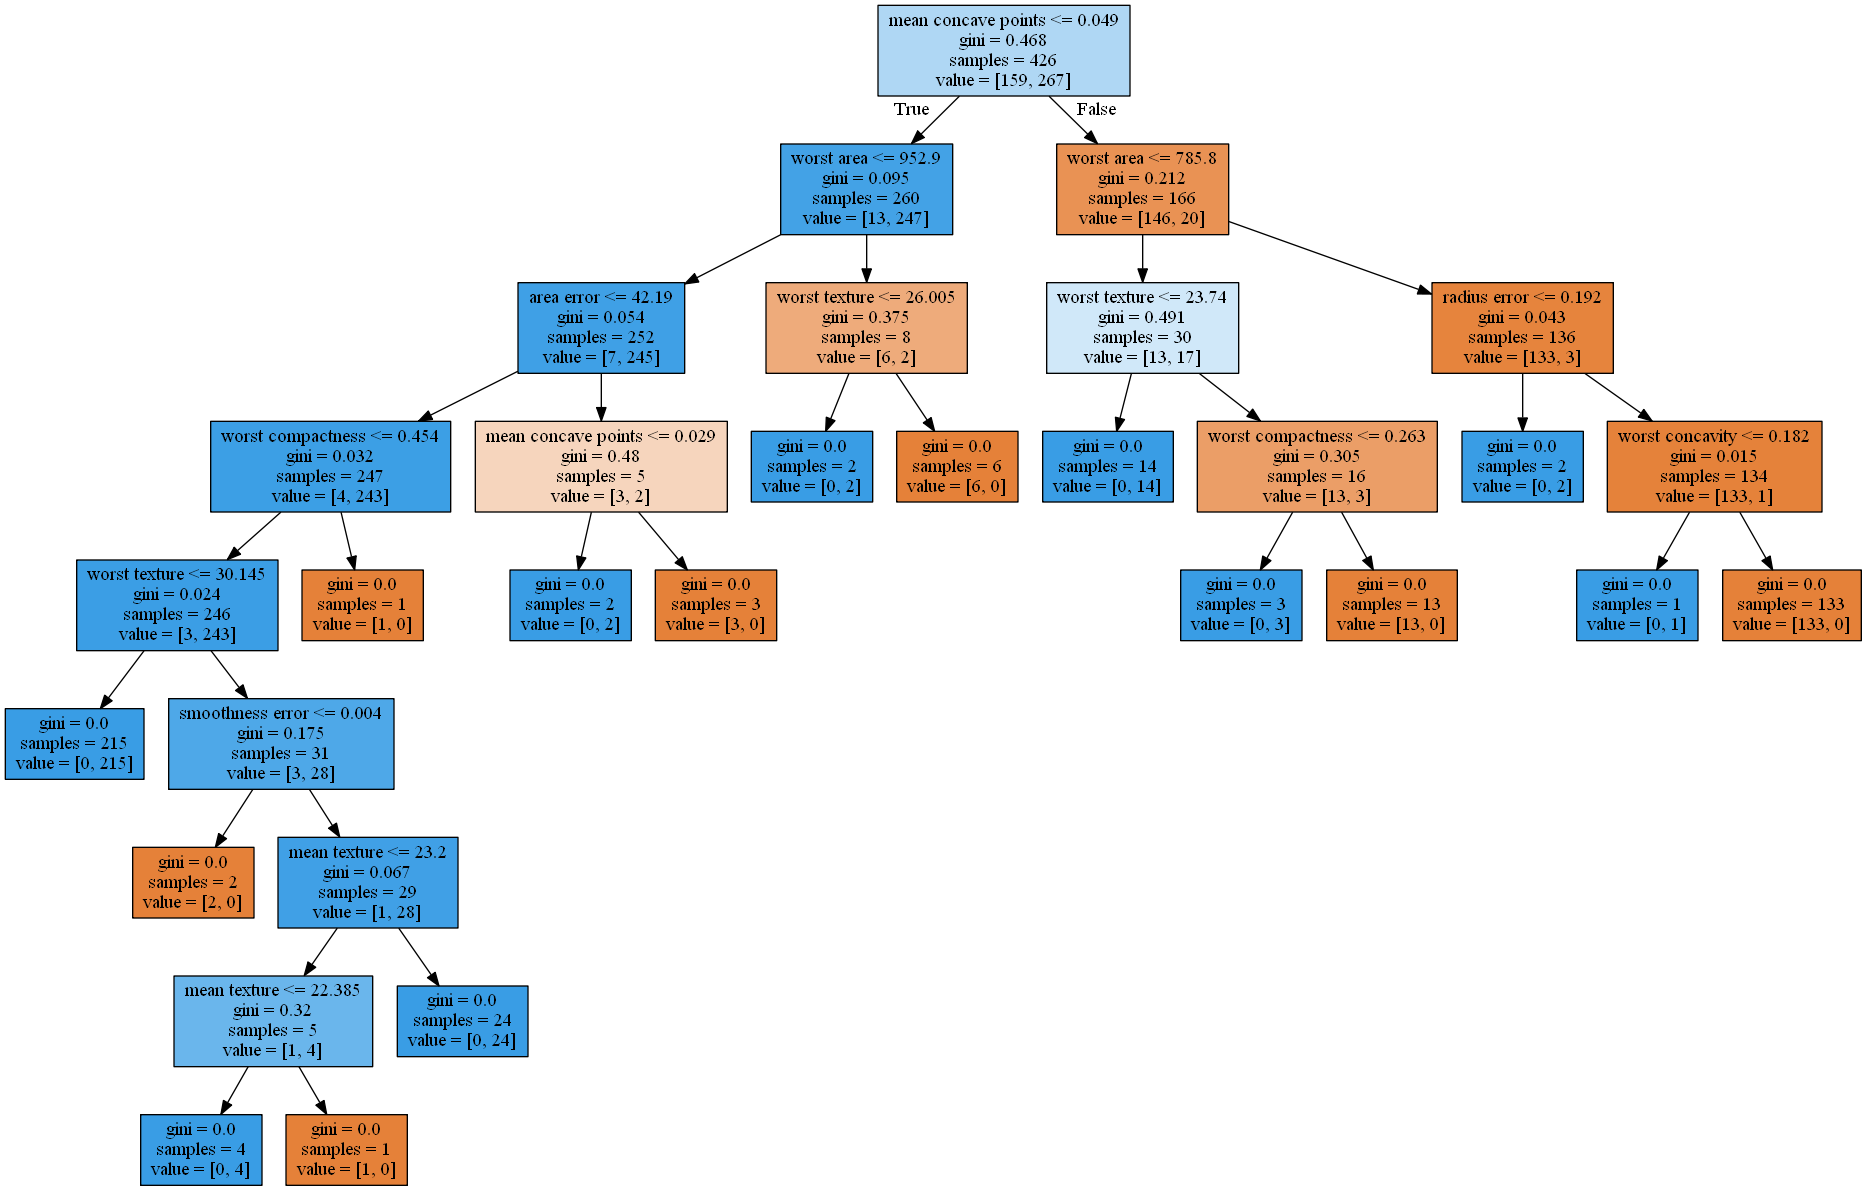

Number of nodes in the 2th tree is: 27 with ccp_alpha: 0.0022664723976040134


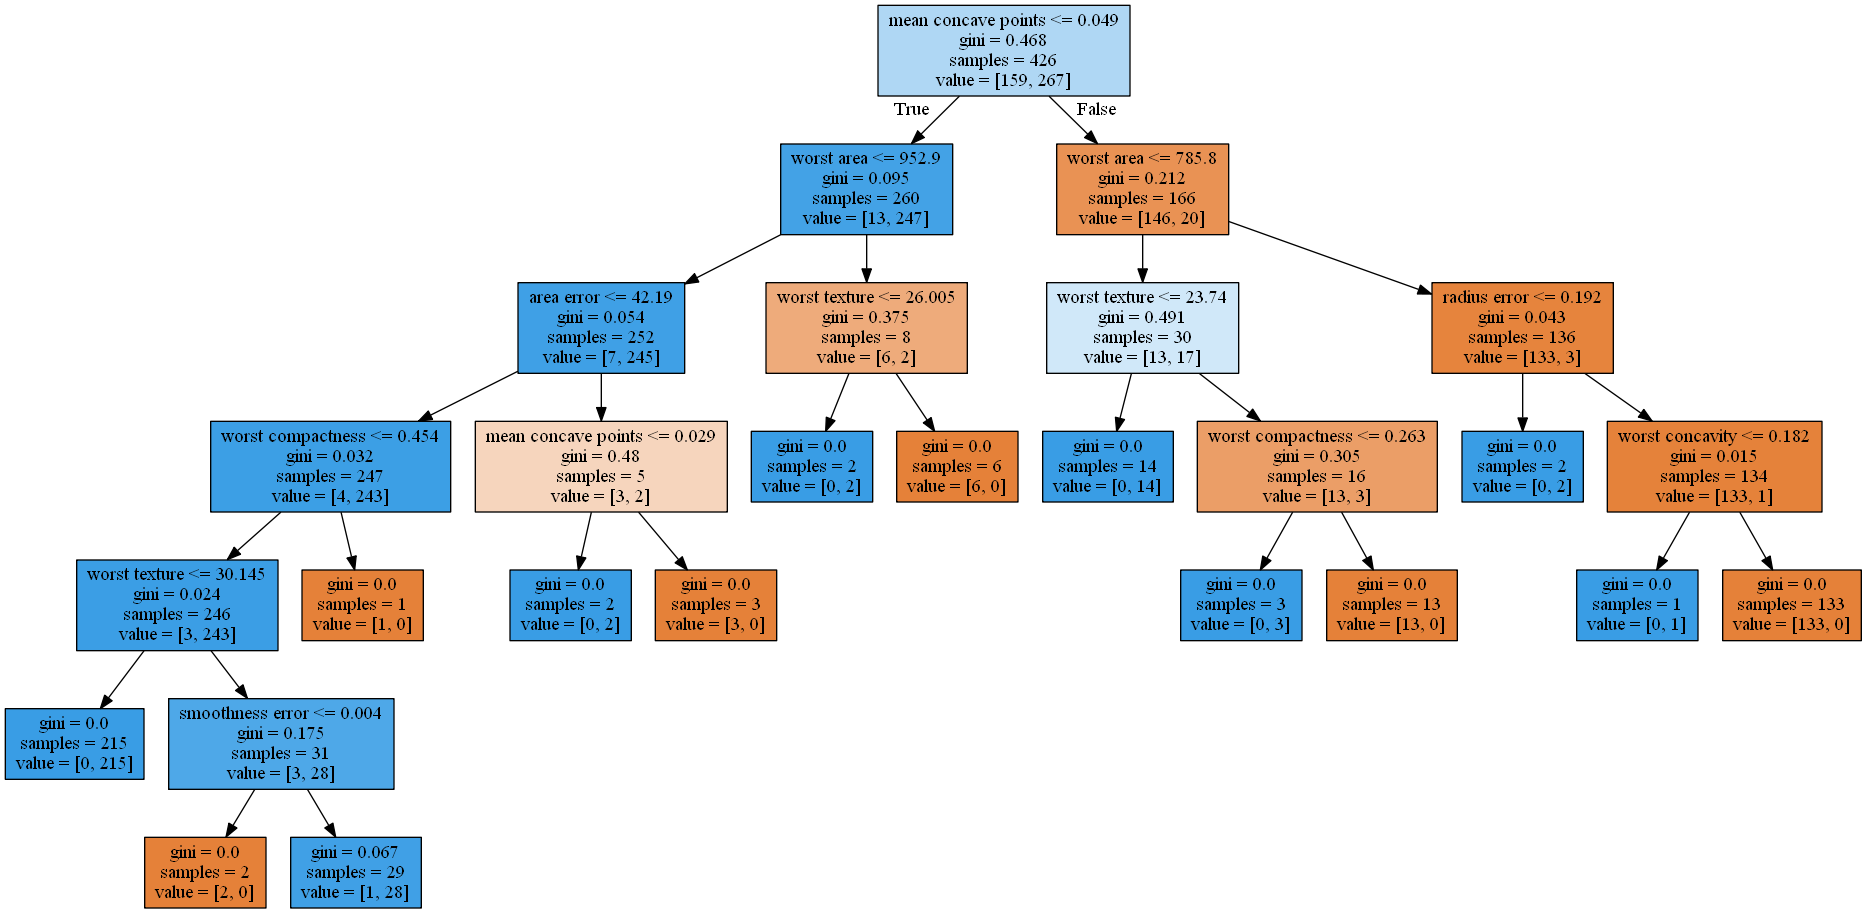

Number of nodes in the 3th tree is: 21 with ccp_alpha: 0.004647426339100881


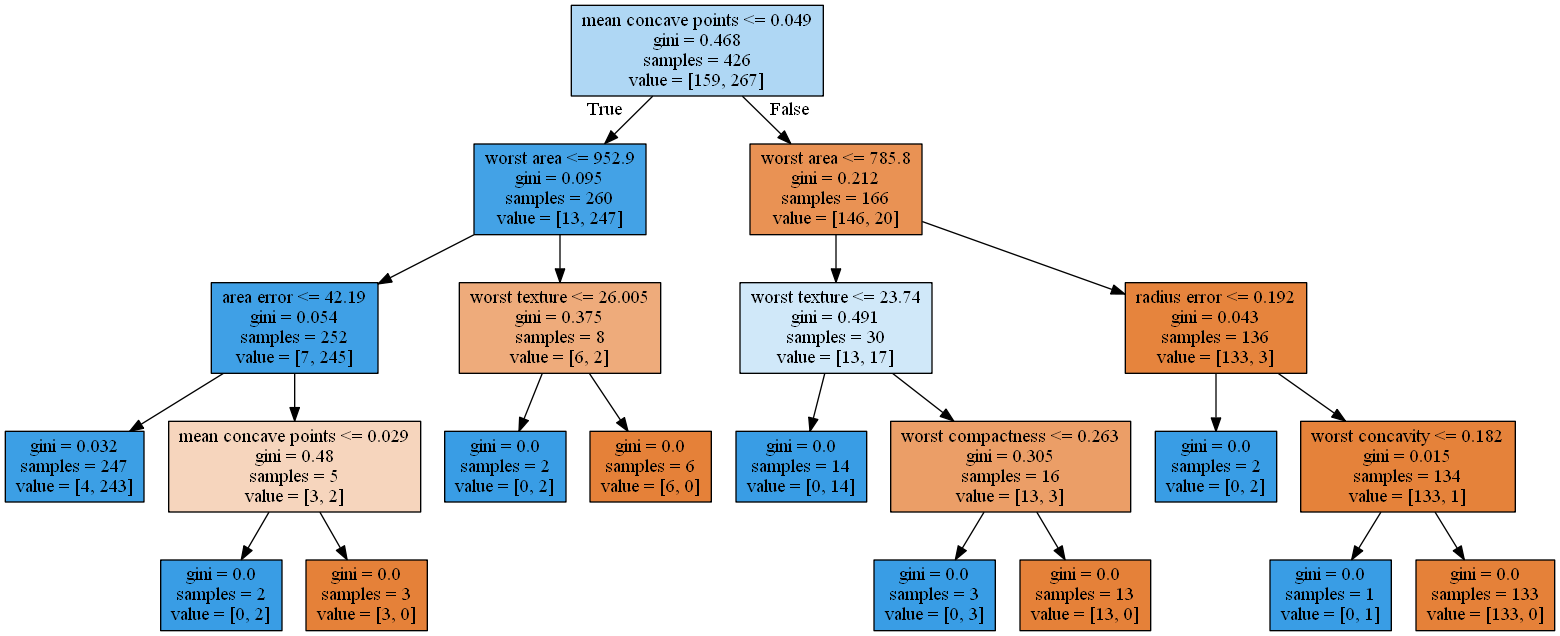

Number of nodes in the 4th tree is: 19 with ccp_alpha: 0.004659799593581376


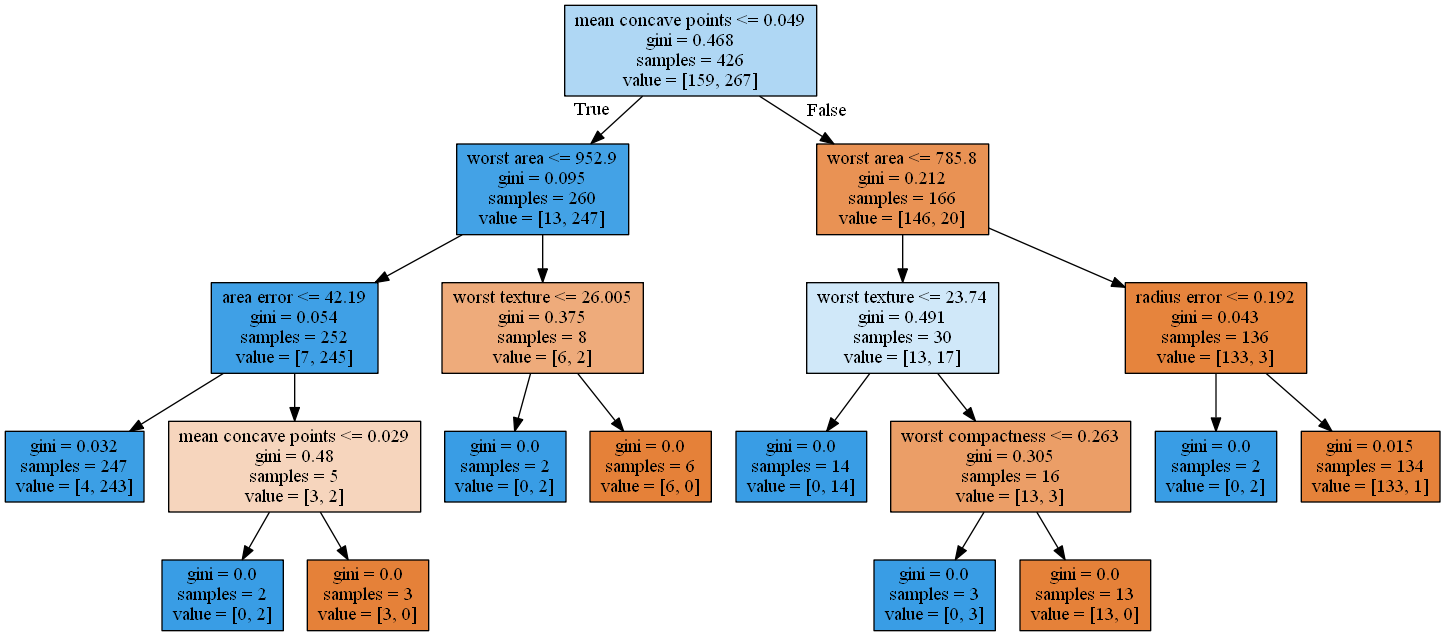

Number of nodes in the 5th tree is: 17 with ccp_alpha: 0.005633802816901408


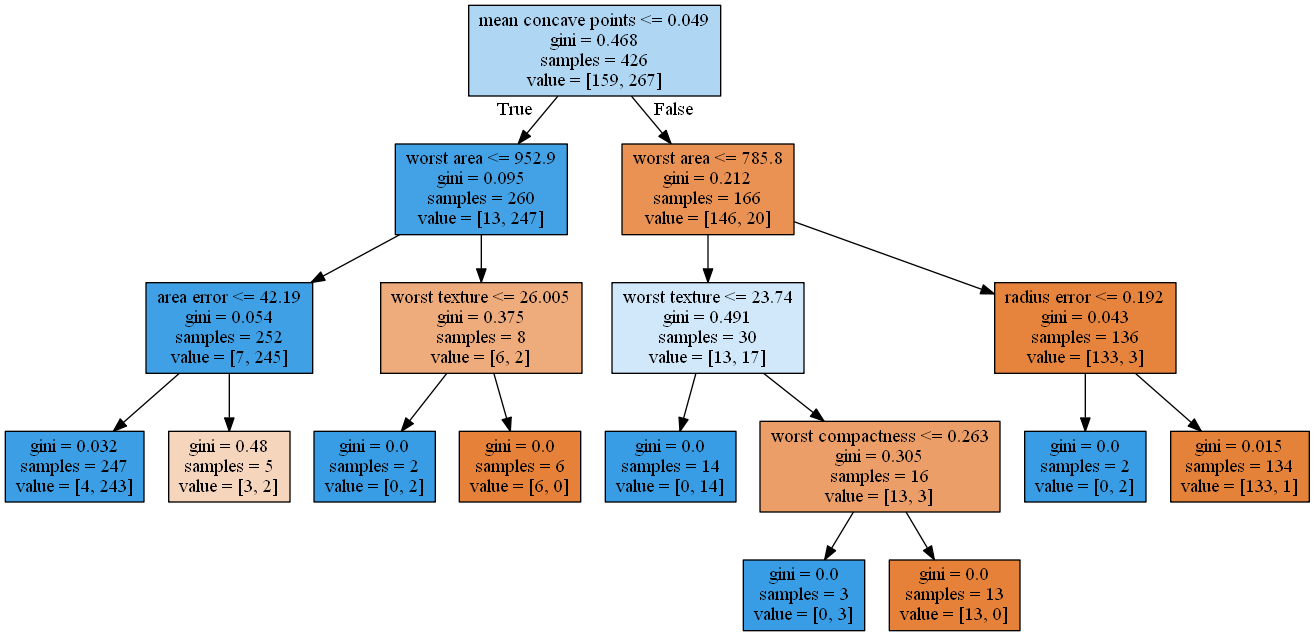

Number of nodes in the 6th tree is: 15 with ccp_alpha: 0.007042253521126761


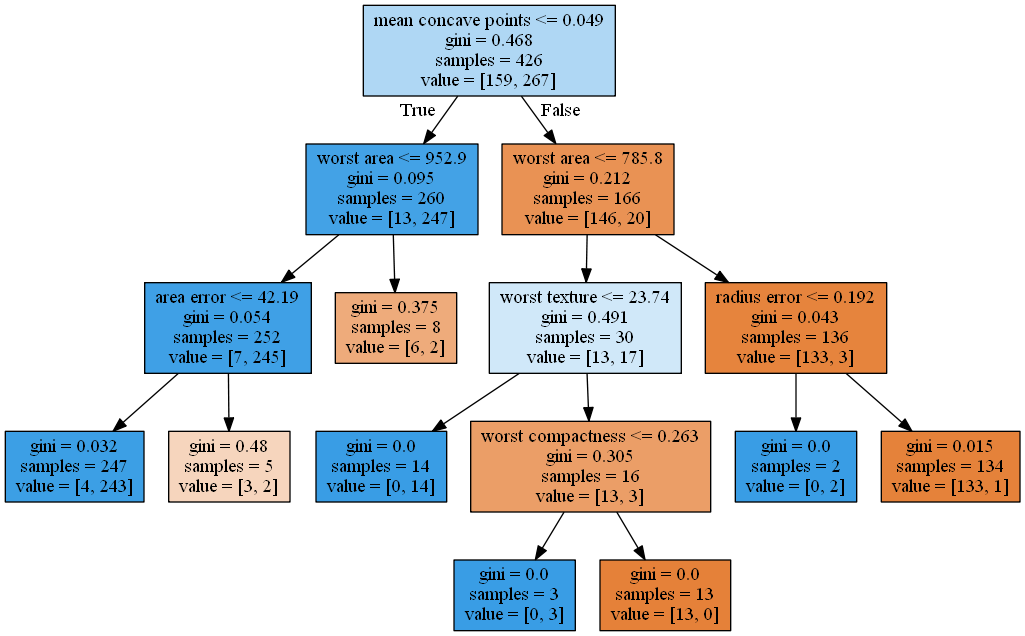

Number of nodes in the 7th tree is: 13 with ccp_alpha: 0.007841938420144537


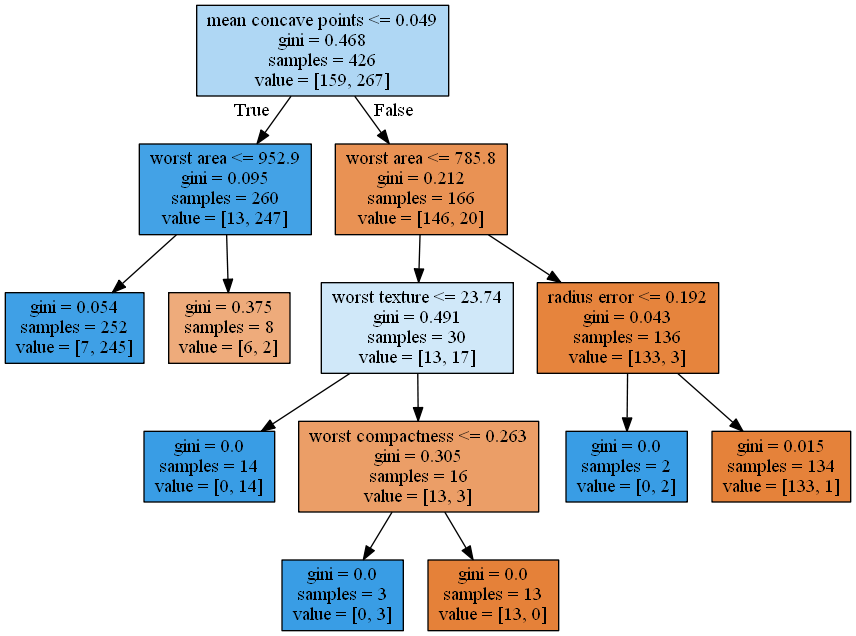

Number of nodes in the 8th tree is: 11 with ccp_alpha: 0.009114019793328328


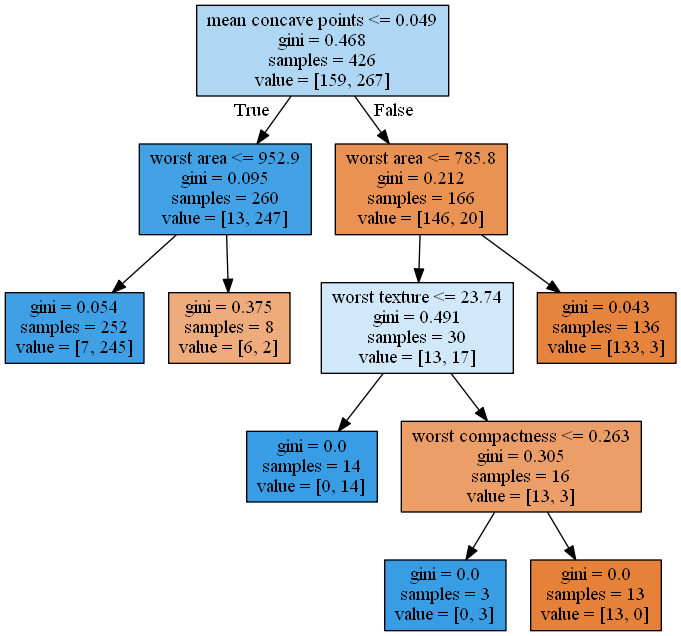

Number of nodes in the 9th tree is: 9 with ccp_alpha: 0.011443661971830986


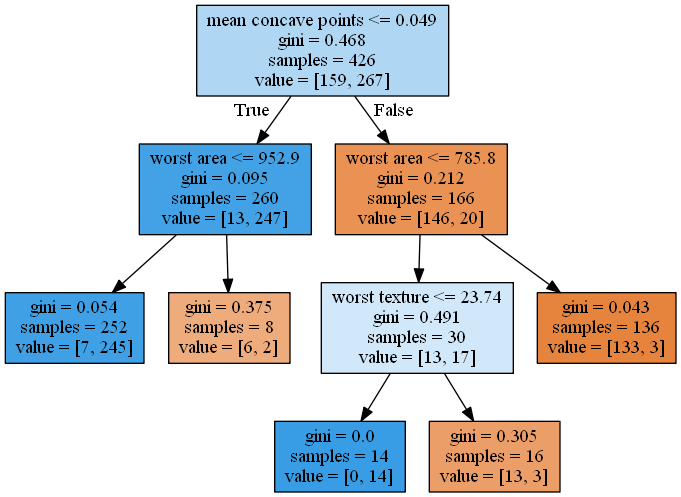

Number of nodes in the 10th tree is: 7 with ccp_alpha: 0.018988002086593604


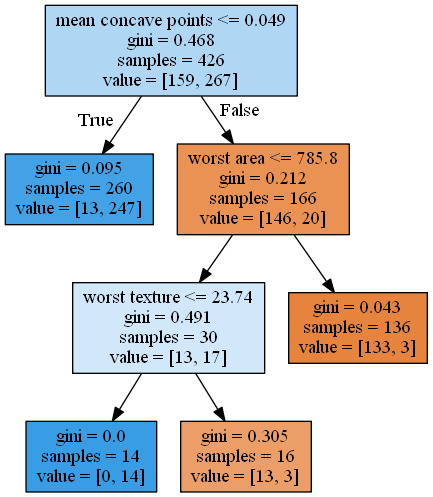

Number of nodes in the 11th tree is: 5 with ccp_alpha: 0.023141627543035996


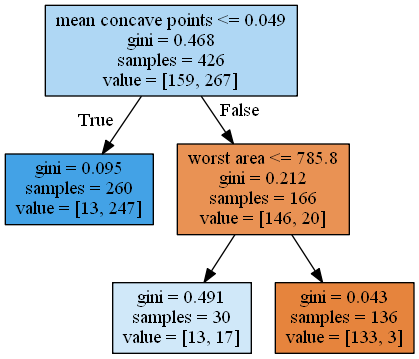

Number of nodes in the 12th tree is: 3 with ccp_alpha: 0.03422474765119576


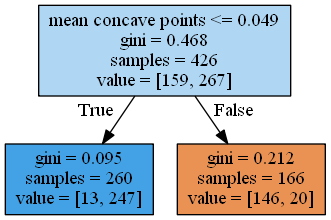

Number of nodes in the 13th tree is: 1 with ccp_alpha: 0.3272984419327777


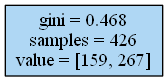

In [11]:
clfs = []
cnt = 0
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree = clf.fit(X_train, y_train)
    cnt += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(cnt, tree.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(tree, ft, node_ids = False))
    print("========================================================================================================")
    clfs.append(clf)

For the remainder of this example, we remove the last element in
``clfs`` and ``ccp_alphas``, because it is the trivial tree with only one
node. Here we show that the number of nodes and tree depth decreases as alpha
increases.



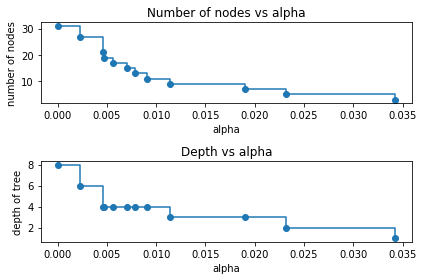

In [12]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Accuracy vs alpha for training and testing sets
----------------------------------------------------
When ``ccp_alpha`` is set to zero and keeping the other default parameters
of :class:`DecisionTreeClassifier`, the tree overfits, leading to
a 100% training accuracy and 88% testing accuracy. As alpha increases, more
of the tree is pruned, thus creating a decision tree that generalizes better.
In this example, setting ``ccp_alpha=0.015`` maximizes the testing accuracy.



In [13]:
clf_ori.score(X_test, y_test)

0.8811188811188811

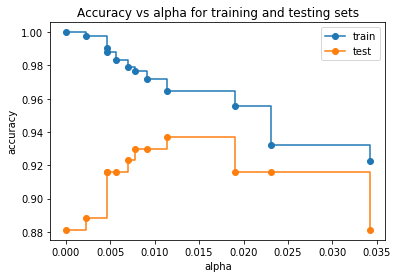

Decision tree without pruning : 31 nodes, 0.881 accuracy
Decision tree with the best pruning : 9 nodes, 0.937 accuracy


In [14]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(clf_ori.tree_.node_count, clf_ori.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))